Reference: https://gregorygundersen.com/blog/2019/08/13/bocd/

#### Setup

A `changepoint` is an underlying shift in the parameters that generate a data sequence (e.g. the mean of a Gaussian suddenly jumps). Here, we focus on the online task

To do this, after getting data point $x_t$, we track a latent run-length $r_t$ that counts how many data points have been generated by the current set of parameters (excluding last changepoint itself), or how many time steps since the last changepoint

  - If no changepoint occurs at $t$, the run length grows by one $r_t = r_{t-1}+1$
  - If a changepoint occurs, we reset $r_t=0$ for the brand-new current run

See figure below for illustration

We want to recursively update

  - full run length `posterior` $p(r_t|x_{1:t})$ after receiving new data $x_t$
  - sequence `predictive distribution` $p(x_{t+1}|x_{1:t})$


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import norm, uniform
import time

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

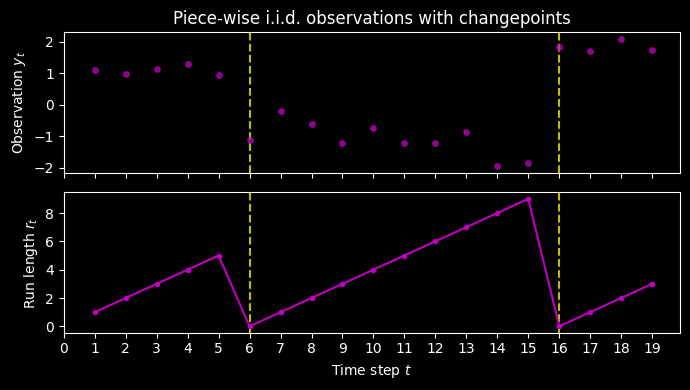

In [27]:
np.random.seed(42)

# first entry of each seg is changepoint, unless it is the first seg
segment_lengths = [5, 10, 4]
segment_means = [1,  -1., 2]
segment_stds = [0.2, 0.5, 0.3]

y_vals = []
run_len = []
current = 0
for idx, (seg_len, mu, sigma) in enumerate(zip(segment_lengths, segment_means, segment_stds)):
    if idx == 0:
        y_vals.append(np.random.normal(mu, sigma, size=seg_len))
        run_len.append(np.arange(1, seg_len+1))
        current += seg_len
    else:
        y_vals.append(np.random.normal(mu, sigma, size=seg_len))
        run_len.append(np.arange(0, seg_len))
        current += seg_len

y = np.concatenate(y_vals)
r = np.concatenate(run_len)
t = np.arange(1, len(y) + 1)

change_points = np.cumsum(segment_lengths)[:-1] + 1

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 4))

ax[0].scatter(t, y, c='m', s=15, alpha=0.7)
for cp in change_points:
    ax[0].axvline(cp, color= 'y',linestyle='--',zorder=-1)


ax[0].set_ylabel(r'Observation $y_t$')
ax[0].set_title('Piece-wise i.i.d. observations with changepoints')

ax[1].plot(t, r, 'm.-')
for cp in change_points:
    ax[1].axvline(cp, color= 'y',linestyle='--',zorder=-1)

ax[1].set_ylabel(r'Run length $r_t$')
ax[1].set_xlabel('Time step $t$')
ax[1].set_xticks(np.arange(0, len(y)+1))

fig.tight_layout()
plt.show()

#### Predictive distribution

Using marginalization, we can write the `predictive` as

$$
\begin{align*}
p(x_{t+1}|x_{1:t})&=\sum_{r_t=0}^tp(x_{t+1}|r_t, x_{t-r_t:t})p(r_t|x_{1:t}) \\
&=\sum_{r_t=0}^tp(x_{t+1}|r_t, x_t^{(r)})p(r_t|x_{1:t})
\end{align*}
$$

where $x_t^{(r)}$ denotes the portion of $x_{1:t}$ that belongs to the `current` run

This shows that `sequence predictive` is determined by $p(x_{t+1}|r_t, x_t^{(r)})$ and `run length posterior` $p(r_t|x_{1:t})$

$p(x_{t+1}|r_t, x_t^{(r)})$ is often refered to as underlying probabilistic model `(UPM) predictive` to distinguish it from sequence predictive $p(x_{t+1}|x_{1:t})$

Next, we look at run length posterior and UPM predictive

#### Run length posterior

To compute `run length posterior`, we use the expression of conditional probability

$$\begin{align*}
p(r_t|x_{1:t})&=\frac{p(r_t, x_{1:t})}{\sum_{r_{t'}}p(r_{t'},x_{1:t})}
\end{align*}$$

We express the joint in a `recursive` manner

$$\begin{align*}
p(r_t, x_{1:t})&=\sum_{r_{t-1}}p(r_t, r_{t-1}, x_t, x_{1:t-1}) \\
&=\sum_{r_{t-1}}p(r_t, x_t | r_{t-1},  x_{1:t-1})p(r_{t-1}, x_{1:t-1})\\
&=\sum_{r_{t-1}}p(x_t|r_t, r_{t-1}, x_{1:t-1})p(r_t|r_{t-1}, x_{1:t-1})p(r_{t-1}, x_{1:t-1}) \\
& \text{assumption: } x_t \text{ conditionally independent of } r_t \\
& \text{assumption: } r_t \text{ conditionally independent of } x_{1:t-1} \\
&=\sum_{r_{t-1}}p(x_t|r_{t-1}, x_{1:t-1})p(r_t|r_{t-1})p(r_{t-1}, x_{1:t-1})\\
&=\sum_{r_{t-1}}p(x_t|r_{t-1}, x_{t-1}^{(r)})p(r_t|r_{t-1})p(r_{t-1}, x_{1:t-1})\\
\end{align*}$$

Therefore, the joint at step $t$, $p(r_t, x_{1:t})$, depends on UPM predictive $p(x_t|r_{t-1}, x_{t-1}^{(r)})$ and joint $p(r_{t-1}, x_{1:t-1})$ at step $t-1$ plus a changepoint prior $p(r_t|r_{t-1})$

It is noted from derivation above that once we set the initial joint $p(r_0)$, what remains to do is to efficiently update UPM predictive and compute changepoint prior

#### Conjugacy

The computation of UPM predictive leverages `conjugate model`

Assume we have observations $D$, model parameters $\eta$ and hyperparameters $\nu$. Then the prior predictive distribution marginalized over parameters can be written as

$$p(x|\nu)=\int p(x|\eta)p(\eta |\nu)d\eta$$

where $p(x|\eta)$ is `predictive model` given parameters and $(\eta |\nu)$ is the prior of `parameters`

This is called `prior predictive distribution` because this is the prediction `before` we observe any data (that is, $D$ is not taken into account)

Similarly, we can write `posterior predictive distribution` as

$$
\begin{align*}
p(x|D, \nu)&=\int p(x|\eta)p(\eta |D, \nu)d\eta \\
\end{align*}
$$

A wonderful property of `conjugate` model is that the prior distribution and posterior distribution are of the same form. Therefore, if the prior and posterior of parameter are conjugate w.r.t. certain likelihood function, then we have

$$p(\eta|D, \nu) = p(\eta | \nu')$$

and

$$
\begin{align*}
p(x|D, \nu)&=\int p(x|\eta)p(\eta |D, \nu)d\eta \\
&=\int p(x|\eta)p(\eta |\nu')d\eta\\
&=p(x|\nu')
\end{align*}
$$

That is, the posterior predictive distribution is in the `same form` as the prior predictive with only changed hyperparameters $\nu'$

This allows us to bypass the whole integration thing provided that we can compute $\nu'$

##### Posterior of parameters in Gaussian

As an example, consider a Gaussian distribution with parameter $\mu$ and `fixed` variance $\sigma^2$, where $\mu$ is determined by two hyperparameters $\mu_0$ and $\sigma_0^2$, or with `prior` $\mu \sim N(\mu_0, \sigma_0^2)$

If we have $n$ data points $x_{1:n}$, we can write out the `likelihood`

$$
\begin{align*}L(x_{1:n}|\mu, \sigma^2)&=\prod_{i=1}^n p(x_i|\mu) \\
&=\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^n \exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^n(x_i-\mu)^2\right]
\end{align*}$$

We can now write the `joint`

$$
\begin{align*}
p(x_{1:n}, \mu) &= \frac{1}{\sqrt{2\pi \sigma_0^2}}\exp\left[-\frac{1}{2\sigma_0^2}(\mu-\mu_0)^2\right]\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^n \exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^n(x_i-\mu)^2\right]\\
&\propto \exp\left[-\frac{1}{2\sigma_0^2}\left(\mu^2-2\mu \mu_0+\mu_0^2\right)-\frac{1}{2\sigma^2}\sum_{i=1}^n\left(x_i^2-2x_i\mu+\mu^2\right)\right]\\
&=\exp \left[-\frac{\mu^2}{2\sigma_0^2}+\frac{\mu\mu_0}{\sigma_0^2}-\frac{\mu_0^2}{2\sigma_0^2}-\frac{1}{2\sigma^2}\sum_{i=1}^n x_i^2 +\frac{\mu}{\sigma^2}\sum_{i=1}^nx_i -\frac{\mu^2}{2\sigma^2}n\right] \\
&\propto \exp\left[-\frac{\mu^2\sigma^2+\mu^2\sigma_0^2n}{2\sigma_0^2\sigma^2}+\frac{\mu\mu_0\sigma^2+\mu\sigma_0^2\sum_{i=1}^nx_i}{\sigma_0^2\sigma^2}\right] \\
&=\exp\left[-\frac{1}{2\sigma_0^2\sigma^2}\left((\sigma^2+\sigma_0^2n)\mu^2-2(\mu_0\sigma^2+\sigma_0^2\sum_{i=1}^nx_i)\mu\right)\right]\\
&=\exp\left[-\frac{1}{2\sigma_0^2\sigma^2}\left(a\mu^2+b\mu+c\right)\right] \\
&=\exp\left[-\frac{1}{2\sigma_0^2\sigma^2}\left(a(\mu-d)^2+e\right)\right]\\
a&=\sigma^2+\sigma_0^2n \\
d&=-\frac{b}{2a}=\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n}\\
e&=c-\frac{b^2}{4a}=-\frac{(\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i)^2}{\sigma^2+\sigma_0^2n} \\
&=\exp\left[-\frac{1}{2\sigma_0^2\sigma^2}\left((\sigma^2+\sigma_0^2n)\left(\mu-\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n}\right)^2-\frac{(\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i)^2}{\sigma^2+\sigma_0^2n}\right)\right] \\
&\propto \exp\left[-\frac{\sigma^2+\sigma_0^2n}{2\sigma_0^2\sigma^2}\left(\mu-\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n}\right)^2\right]
\end{align*}
$$

Using Bayes' rule, we know that `posterior` is proportional to this joint and therefore

$$p(\mu|x_{1:n})\propto \exp\left[-\frac{\sigma^2+\sigma_0^2n}{2\sigma_0^2\sigma^2}\left(\mu-\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n}\right)^2\right]$$

which is a Gaussian distribution as well

The posterior `variance` is

$$\sigma_n^2 = \left[\frac{\sigma_0^2\sigma^2}{\sigma^2+\sigma_0^2}\right]^2$$

or

$$
\begin{align*}
\frac{1}{\sigma_n^2} &=\frac{\sigma^2+\sigma_0^2n}{\sigma_0^2\sigma^2} \\
&=\frac{\sigma^2}{\sigma_0^2\sigma^2}+\frac{\sigma_0^2}{\sigma^2\sigma_0^2}n \\
&=\frac{1}{\sigma_0^2}+\frac{1}{\sigma^2}n
\end{align*}
$$

and

$$\sigma_n^2 =\frac{\sigma_0^2\sigma^2}{\sigma^2+\sigma_0^2n}= \frac{1}{\frac{1}{\sigma_0^2}+\frac{1}{\sigma^2}n}$$

The posterior `mean` is

$$
\begin{align*}
\mu_n &= \frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n} \\
&=\frac{\sigma^2}{\sigma^2+\sigma_0^2n}\mu_0+\frac{\sigma_0^2}{\sigma^2+\sigma_0^2n}\sum_{i=1}^nx_i \\
&=\sigma_n^2\left(\frac{\mu_0}{\sigma_0^2}+\frac{1}{\sigma^2}\sum_{i=1}^nx_i\right)
\end{align*}$$

Recall that $\frac{1}{n}\sum_{i=1}^nx_i$ is the `maximum likelihood` estimate of $\mu$

So the posterior mean is a weighted sum of prior mean $\mu_0$ and the ML estimate $\mu_{ML}$


##### Derivation from perspective of optimization

Because the posterior $p(\mu| x_{1:n})$ is Gaussian, therefore, the center of posterior density is also the maximum-a-posteriori (MAP) estimate of the mean $\mu_n=\mu_{\text{MAP}}$

If we just want to get this MAP estimate, we can take derivative of $\log p(\mu|x_{1:n})$ or for calculation, the log of joint $\log p(x_{1:n}, \mu)$ (since the difference in constant vanishes after differentiation)

$$
\begin{align*}
\frac{d}{d\mu}\log p(x_{1:n}, \mu)&=\frac{d}{d\mu}\left[-\frac{1}{2\sigma_0^2}(\mu-\mu_0)^2-\frac{1}{2\sigma^2}\sum_{i=1}^n(x_i-\mu)^2+\text{const.}\right] \\
&=\frac{d}{d\mu}\left[-\frac{1}{2\sigma_0^2}(\mu^2-2\mu\mu_0)-\frac{1}{2\sigma^2}\left(n\mu^2-2\mu\sum_{i=1}^nx_i\right)+\text{const.}\right] \\
& \text{group } \mu^2 \text{ and } \mu \\
&=\frac{d}{d\mu}\left[-\frac{\sigma^2+n\sigma_0^2}{2\sigma_0^2\sigma^2}\mu^2+\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma_0^2\sigma^2}\mu +\text{const.}\right]
\end{align*}
$$

and set to zero, we have

$$\frac{\sigma^2+n\sigma_0^2}{\sigma_0^2\sigma^2}\mu=\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma_0^2\sigma^2} $$

Solve for the MAP estimate

$$\mu_{\text{MAP}}=\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+n\sigma_0^2}$$

which is the same as the posterior mean $\mu_n$ we get earlier

Both approaches, taking the derivative or completing the square, are mathematically identical

The latter just skips writing the derivative because the result can be read off immediately once the quadratic is centered

Same can be done for posterior variance

Since the posterior is Gaussian, we know

$$\log p(\mu|x_{1:n})=-\frac{1}{2\sigma_n^2}(\mu-\mu_n)^2+\text{const.}$$

Take second derivative w.r.t. $\mu$

$$
\begin{align*}
\left.\frac{d^2}{d\mu^2}\log p(\mu|x_{1:n})\right|_{\mu=\mu_n}
&=\left.\frac{d^2}{d\mu^2}\log p(\mu,x_{1:n})\right|_{\mu=\mu_n}\\
&=-\frac{1}{\sigma_n^2} \\
&=-\frac{\sigma^2+n\sigma_0^2}{\sigma_0^2\sigma^2}
\end{align*}
$$

and we get posterior variance as before

$$\sigma_n^2 =\frac{\sigma_0^2\sigma^2}{\sigma^2+n\sigma_0^2}$$

#### Exponential family

More generally, it is the exponential family that is of interest

Standard distributions can be cast into a canonical form (we can think of it as `likelihood`)

$$p(x|\eta)=h(x)g(\eta)\exp \left[\eta^T u(x)\right]$$

where
  - $h(x)$ is `underlying measure` carrying every factor that does not involve $\eta$
  - $u(x)$ is sufficient-statistic of `data`
  - $\eta$ is `natural-parameter`
  - $g(\eta)$ is normalizer

$$\begin{align*}
g(\eta) \int h(x) \exp\left[\eta^T u(x)\right]dx=1
\end{align*}$$

##### Sufficient statistic

For data $x_{1:n}$, the idea of sufficient statistic is that we can use

$$\sum_{i=1}^n u(x_{i})$$

to compute maximum likelihood estimate of natural parameters

Use canonical form, we can write the log-likelihood as

$$
\begin{align*}
\log p(x_{1:n}|\eta)&=\log \prod_{i=1}^n p(x_i|\eta)\\
&=\log \left[\left(\prod_{i=1}^nh(x_i)\right)g(\eta)^n\exp\left(\eta^T\sum_{i=1}^nu(x_i)\right)\right]\\
&=\log \left(\prod_{i=1}^nh(x_i)\right)+n\log g(\eta)+\eta^T\sum_{i=1}^nu(x_i)
\end{align*}
$$

Take gradient w.r.t. $\eta$ and set to zero

$$\nabla n\log g(\eta_{\text{ML}})+\sum_{i=1}^nu(x_i)=0$$

or

$$-\nabla \log g(\eta_{\text{ML}}) = \frac{1}{n}\sum_{i=1}^nu(x_i)$$

Note that since sufficient statistic is a running sum, we can compute it `incrementally` as new data arrives

##### Moments through differentiation

Denote log normalizer

$$A(\eta)=-\log g(\eta)=\log \int h(x)\exp \left[\eta^Tu(x)\right]dx$$

Take gradient w.r.t. $\eta$

$$\nabla A(\eta)=\frac{1}{Z(\eta)}\nabla Z(\eta)$$

where

$$Z(\eta)=\exp[A(\eta)]=\int h(x) \exp\left[\eta^Tu(x)\right]dx$$

Under some mild condition, we can write

$$
\begin{align*}
\nabla Z(\eta)&=\int h(x)u(x)\exp\left[\eta^Tu(x)\right]dx \\
&=\int u(x)Z(\eta)\frac{h(x)\exp\left[\eta^Tu(x)\right]}{Z(\eta)}dx\\
& \text{the fraction is a density on }x\\
&=\mathbb{E}\left[Z(\eta)u(x)\right]\\
&=Z(\eta)\mathbb{E}\left[u(x)\right]
\end{align*}$$

Therefore

$$\nabla A(\eta)=\frac{1}{Z(\eta)}\nabla Z(\eta)=\mathbb{E}\left[u(x)\right]$$

##### Conjugate prior and posterior

For exponential family member, it has a conjugate `prior` of form

$$p(\eta|\chi, \nu)=f(\chi, \nu)g(\eta)^{\nu}\exp\left[\eta^T\chi\right]$$

where $\nu, \chi$ are hyperparameters and $f(\chi, \nu)$ depends on form of exponential family member

We can verify that `posterior` and `prior` are indeed of same form

$$
\begin{align*}
p(\eta|x_{1:n},\chi, \nu) &\propto p(x_{1:n}|\eta)p(\eta|\chi, \nu)\\
&=\left[\left(\prod_{i=1}^nh(x_i)\right)g(\eta)^n\exp\left(\eta^T\sum_{i=1}^nu(x_i)\right)\right]f(\chi, \nu)g(\eta)^{\nu}\exp\left[\eta^T\chi\right]\\
&=\left(\prod_{i=1}^nh(x_i)\right)f(\chi, \nu)g(\eta)^{n+\nu}\exp\left(\eta^T\left(\sum_{i=1}^nu(x_i)+\chi\right)\right)\\
&\propto g(\eta)^{n+\nu}\exp\left(\eta^T\left(\sum_{i=1}^nu(x_i)+\chi\right)\right)\\
\end{align*}
$$

So for posterior

$$\begin{align*}
\nu &= \nu_{\text{prior}}+n \\
\chi &= \chi_{\text{prior}}+\sum_{i=1}^nu(x_i) \\
\end{align*}$$

and

$$\begin{align*}
\nu_t &= \left\{\begin{array}{ll}\nu_{\text{prior}} & t=0 \\ \nu_{t-1}+1 & t>0\end{array}\right.\ \\
\chi_t &= \left\{\begin{array}{ll}\chi_{\text{prior}} & t=0 \\ \chi_{t-1}+u(x_{t}) & t>0\end{array}\right.\ \\
\end{align*}$$

It should be noted that neither natural parameter $\eta$ nor hyperparameters $\chi, \nu$ are necessarily the ones we are familier with (mean, variance)

When we translate back to the more familiar parameters, those same additions are still there, but they appear through whatever nonlinear transformation connects the two parameterizations

##### Posterior of parameters in Gaussian

Use Gaussian as example, with `both` mean and variance as parameters

$$
\begin{align*}
p(x|\mu, \sigma^2)&=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2\sigma^2}(x-\mu)^2\right] \\
&=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2\sigma^2}x^2+\frac{\mu}{\sigma^2}x-\frac{\mu^2}{2\sigma^2}\right]\\
&=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{\mu^2}{2\sigma^2}\right]\exp\left[\frac{\mu}{\sigma^2}x-\frac{1}{2\sigma^2}x^2\right]
\end{align*}
$$

By split like this, we can introduce sufficient statistic and natural parameter

$$u(x)=\begin{bmatrix}x \\ x^2\end{bmatrix}, \eta(\mu, \sigma^2)=\begin{bmatrix}\eta_1\\ \eta_2\end{bmatrix}=\begin{bmatrix}\frac{\mu}{\sigma^2}\\ -\frac{1}{2\sigma^2}\end{bmatrix}$$

In addition

$$h(x)=\frac{1}{\sqrt{2\pi}}, g(\eta)=\frac{1}{\sigma}\exp\left[-\frac{\mu^2}{2\sigma^2}\right]$$

Notice that

$$\frac{1}{\sigma}=\sqrt{-2\eta_2}$$

and

$$-\frac{\mu^2}{2\sigma^2}=\frac{\eta_1^2}{4\eta_2}$$

we can rewrite the normalizer as

$$g(\eta)=\sqrt{-2\eta_2}\exp \left[\frac{\eta_1^2}{4\eta_2}\right]$$

For simplicity, we will go through whole process of getting posterior of parameters using Gaussian example of `fixed` variance

Remember, the `ultimate` goal is to obtain posterior of parameters given data $\mu|x_{1:n}$

We know that doing this is easier for exponential family in natural parameter space than in orginal parameter space, so in short, we do the following steps

  1. identify `conversion` between original `parameter` $\mu$ and natural parameter $\eta$ (by writing density $p(x|\mu)$ in canonical form)
  2. write canonical form `conjugate prior` (which is in natural parameter space with natural hyperparameters, $p(\eta|\chi, \nu)$)
  3. identify `conversion` between original `hyperparameters` and natural hyperparameters, usually done in two substeps
    - 3.1 obtain conjugate prior in `original` parameter space but still expressed in `natural` hyperparameters, $p(\mu|\chi, \nu)$, using conversion in #1
    - 3.2 compare conjugate prior in original parameter space with original hyperparameters and natural hyperparameters
  4. obtain `posterior` in original parameter space expressed in natural hyperparameters (obtained in #3.1), by replacing natural hyperparameters with additively updated values $p(\mu|\chi+\sum u(x_i), \nu+n)$
  5. obtain `posterior` in original parameter space expressed in original hyperparameters, using conversion in #3.2

With fixed variance, we can split `density` (expressed in `original` parameters) as

$$
\begin{align*}
p(x|\mu, \sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2\sigma^2}x^2\right]\exp\left[-\frac{\mu^2}{2\sigma^2}\right]\exp\left[\frac{\mu}{\sigma^2}x\right]
\end{align*}
$$

We can `identify` natural parameters, sufficient statistic, normalizer and underlying measure, expressed in `original` parameters

$$
\begin{align*}
\eta &= \frac{\mu}{\sigma^2}\\
u(x) & = x \\
h(x) &= \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2\sigma^2}x^2\right]\\
g(\eta) & =\exp\left[-\frac{\mu^2}{2\sigma^2}\right]=\exp\left[-\frac{\sigma^2\eta^2}{2}\right]\\
\end{align*}
$$

in order to put everything into canonical form

$$p(x|\eta)=h(x)g(\eta)\exp \left[\eta^T u(x)\right]$$


Then, write canonical form `conjugate prior` (in `natural` parameter space, with `natural` hyperparameters $\chi, \nu$)

$$p(\eta|\chi, \nu)=f(\chi, \nu)g(\eta)^{\nu}\exp\left[\eta^T\chi\right]$$

In the case of fixed variance, we plug in $g(\eta)$ and since $f(\chi, \nu)$ does not depend on $\eta$, we have

$$p(\eta|\chi, \nu)\propto \exp \left[-\frac{\nu\sigma^2}{2}\eta^2+\chi\eta\right] \sim N\left(\eta;\frac{\chi}{\nu\sigma^2},\frac{1}{\nu\sigma^2}\right)$$

Write out conjugate prior of `original` parameters $\mu$, with `natural` hyperparameters, using the conversion between original and natural parameters $\mu=\sigma^2\eta$

$$\mu \sim N\left(\mu; \frac{\chi}{\nu}, \frac{\sigma^2}{\nu}\right)=N(\mu;\mu_0, \sigma_0^2)$$

Identify `conversion` between original hyperparameters ($\mu_0, \sigma_0^2)$ and natural hyperparameters $\chi, \nu$

$$
\begin{align*}
\mu_0&=\frac{\chi}{\nu}\\
\sigma_0^2&=\frac{\sigma^2}{\nu}
\end{align*}
$$

Subscript 0 indicating the mean of prior (that is, taking zero observation into account)

We can also have

$$
\begin{align*}
\chi&=\mu_0\nu\\
\nu&=\frac{\sigma^2}{\sigma_0^2}
\end{align*}
$$

which will be useful when converting from $\chi, \nu$ to $\mu_0, \sigma_0,\sigma$

For `posterior`, which has same form as conjugate prior

Optionally, we can write out posterior of `natural` parameters $\eta$ using additively updated `natural` hyperparameters $\chi', \nu'$

$$\begin{align*}
&p(\eta|x_{1:n})\sim N\left(\eta;\frac{\chi'}{\nu'\sigma^2}, \frac{1}{\nu'\sigma^2}\right) \\
& \text{since }
\nu' = \nu+n,
\chi' = \chi+\sum_{i=1}^nu(x_i) \\
&p(\eta|x_{1:n})\sim N\left(\eta;\frac{\chi+\sum_{i=1}^nu(x_i)}{(\nu+n)\sigma^2}, \frac{1}{(\nu+n)\sigma^2}\right) \\
\end{align*}$$

Or we can directly use posterior of `original` parameters with `natural` hyperparameters

$$\mu \sim N\left(\mu; \frac{\chi}{\nu}, \frac{\sigma^2}{\nu}\right)\rightarrow\mu|x_{1:n} \sim N\left(\mu;\frac{\chi+\sum_{i=1}^nu(x_i)}{\nu+n}, \frac{\sigma^2}{\nu+n}\right) $$

Plug in conversion between original hyperparameters and natural hyperparameters, we can obtain the posterior of original parameters using original hyperparameters (and data points)

$$\begin{align*}
p(\mu|x_{1:n})\sim N\left(\mu;\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+n\sigma_0^2},\frac{\sigma_0^2\sigma^2}{\sigma^2+n\sigma_0^2}\right)=N(\mu; \mu_n, \sigma_n^2)
\end{align*}$$

which is the same as derived earlier using completion of square or optimization method, but without much calculation needed

##### Posterior predictive

The `posterior predictive` is used to predict new observation $\hat{x}$ given the posterior of parameters

$$
\begin{align*}
p(\hat{x}|x_{1:n}) & =\int p(x|\mu)p(\mu|x_{1:n})d\mu \\
&=\int N(x|\mu, \sigma^2)N(\mu|\mu_n, \sigma_n^2)d\mu\\
&=N(x; \mu_n, \sigma_n^2+\sigma^2)
\end{align*}
$$

As we can see, this is readily available once we have the posterior of $\mu$

#### Changepoint prior

To compute the changepoint prior $p(r_t|r_{t-1})$, we define the following functions

  - $f(\tau)$: prior probability that the current run will end right after the $\tau$th data point. This is the prior knowledge before seeing any data
  - $S(\tau)$: survival function that current run is alive at least until the $\tau$th data point has been obtained
  - $H(\tau)=f(\tau)/S(\tau)$: hazard function that `conditioned` on having survived through the $(\tau-1)$th data point, the probability the current run `terminates` right after the $\tau$th data point is observed

More explicitly

$$H(\tau)=p(T=\tau | T\geq\tau)=\frac{p(T=\tau)}{p(T\geq \tau)}=\frac{f(\tau)}{S(\tau)}$$

Therefore, the changepoint prior is a discrete probability distribution of two states

$$p(r_t|r_{t-1})=\left\{\begin{array}{ll}H(r_{t-1}+1) & r_t=0 \\ 1-H(r_{t-1}+1) & r_t=r_{t-1}+1\end{array}\right.$$

That is, `before` we look at $x_t$, the model says “with prior probability $H(r_{t-1}+1)$ the current run will `end` right after this sample, otherwise it will continue”